# Tokenization

In [1]:
with open("../the-verdict.txt", "r", encoding="utf-8") as f:
 raw_text = f.read()
print("Total number of character:", len(raw_text))
print(raw_text[:99])

Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [2]:
import re
text = "Hello, world. Is this-- a test?"
result = re.split(r'([,.:;?_!"()\']|--|\s)', text)
result = [item.strip() for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


In [3]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(len(preprocessed))

4690


In [4]:
print(preprocessed[:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


![alt text](image.png)

In [5]:
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)
print(vocab_size)

1130


### Creating a vocab and giving them a token ids

In [6]:
vocab = {token:integer for integer,token in enumerate(all_words)}
for i, item in enumerate(vocab.items()):
 print(item)
 if i >= 20:
    break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)


![alt text](image-1.png)

## Implementing a simple text tokenizer

In [7]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab 
        self.int_to_str = {i:s for s,i in vocab.items()} 
        
    def encode(self, text): 
        preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
        preprocessed = [ item.strip() for item in preprocessed if item.strip()]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
    
    def decode(self, ids): 
        text = " ".join([self.int_to_str[i] for i in ids]) 
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text) 
        return text

In [8]:
tokenizer = SimpleTokenizerV1(vocab)
text = """  "It's the last he painted, you know," 
            Mrs. Gisburn said with pardonable pride.
    """
ids = tokenizer.encode(text)
print(ids)

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


In [9]:
print(tokenizer.decode(ids))

" It' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.


In [10]:
# Testing on a sample
text = "Hello, do you like tea?"
print(tokenizer.encode(text))

KeyError: 'Hello'

- The problem is that the word “Hello” was not used in the “The Verdict” short story. 
- Hence, it is not contained in the vocabulary. This highlights the need to consider large and diverse training sets to extend the vocabulary when working on LLMs.

### Adding special context tokens \<UNK> and \<EOS>

In [11]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])
vocab = {token:integer for integer,token in enumerate(all_tokens)}
print(len(vocab.items()))

1132


In [12]:
for i, item in enumerate(list(vocab.items())[-5:]):
 print(item)

('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|endoftext|>', 1130)
('<|unk|>', 1131)


In [13]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = { i:s for s,i in vocab.items()}
    
    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [
            item if item in self.str_to_int 
            else "<|unk|>" for item in preprocessed
                        ]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
    
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text) 
        return text

In [14]:
text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."
text = " <|endoftext|> ".join((text1, text2))
print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


In [15]:
tokenizer = SimpleTokenizerV2(vocab)
print(tokenizer.encode(text))

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]


In [16]:
print(tokenizer.decode(tokenizer.encode(text)))

<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.


# Byte-Pair Encoding (BPE)

In [17]:
# %pip install -q tiktoken

In [18]:
from importlib.metadata import version
import tiktoken
print("tiktoken version:", version("tiktoken"))

tiktoken version: 0.8.0


In [19]:
tokenizer = tiktoken.get_encoding("gpt2")

In [20]:
text = (
 "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
 "of someunknownPlace."
)
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(integers)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]


In [21]:
strings = tokenizer.decode(integers)
print(strings)

Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.


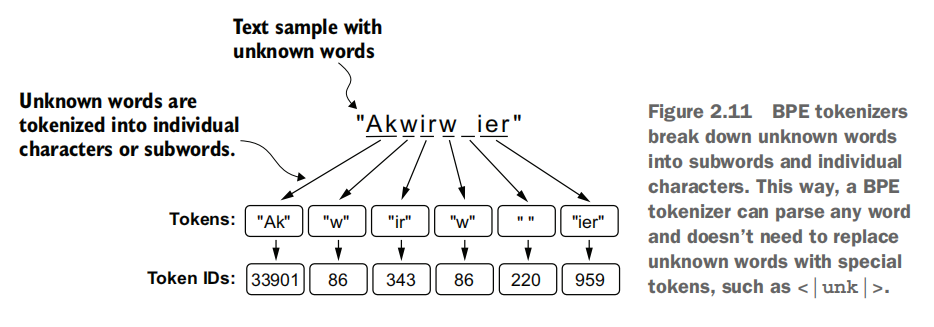

The algorithm underlying BPE breaks down words that aren’t in its predefined \
vocabulary into smaller subword units or even individual characters, enabling it to\
handle out-of-vocabulary words. So, thanks to the BPE algorithm, if the tokenizer\
encounters an unfamiliar word during tokenization, it can represent it as a sequence\
of subword tokens or characters, as illustrated in figure.

# Data sampling with a sliding window
### The next word prediction task

![alt text](image-2.png)

In [22]:
with open("../the-verdict.txt", "r", encoding="utf-8") as f:
 raw_text = f.read()
enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

5145


In [23]:
enc_sample = enc_text[50:]

In [24]:
context_size = 4 
x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]
print(f"x: {x}")
print(f"y:      {y}")

x: [290, 4920, 2241, 287]
y:      [4920, 2241, 287, 257]


In [25]:
for i in range(1, context_size+1):
 context = enc_sample[:i]
 desired = enc_sample[i]
 print(context, "---->", desired)

[290] ----> 4920
[290, 4920] ----> 2241
[290, 4920, 2241] ----> 287
[290, 4920, 2241, 287] ----> 257


In [26]:
for i in range(1, context_size+1):
 context = enc_sample[:i]
 desired = enc_sample[i]
 print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

 and ---->  established
 and established ---->  himself
 and established himself ---->  in
 and established himself in ---->  a


## A dataset for batched inputs and targets

In [70]:
import torch
from torch.utils.data import Dataset, DataLoader
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []
        token_ids = tokenizer.encode(txt) 
        for i in range(0, len(token_ids) - max_length, stride): 
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1] #[-1] why not take only the last element from here?
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
    def __len__(self): 
        return len(self.input_ids)
    def __getitem__(self, idx): 
        return self.input_ids[idx], self.target_ids[idx]

In [71]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2") 
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride) 
    dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=shuffle,
    drop_last=drop_last, 
    num_workers=num_workers 
    )
    return dataloader

In [72]:
with open("../the-verdict.txt", "r", encoding="utf-8") as f:
 raw_text = f.read()
dataloader = create_dataloader_v1(
 raw_text, batch_size=1, max_length=8, stride=2, shuffle=False)
data_iter = iter(dataloader) 
first_batch = next(data_iter)
print(first_batch)

[tensor([[  40,  367, 2885, 1464, 1807, 3619,  402,  271]]), tensor([[  367,  2885,  1464,  1807,  3619,   402,   271, 10899]])]


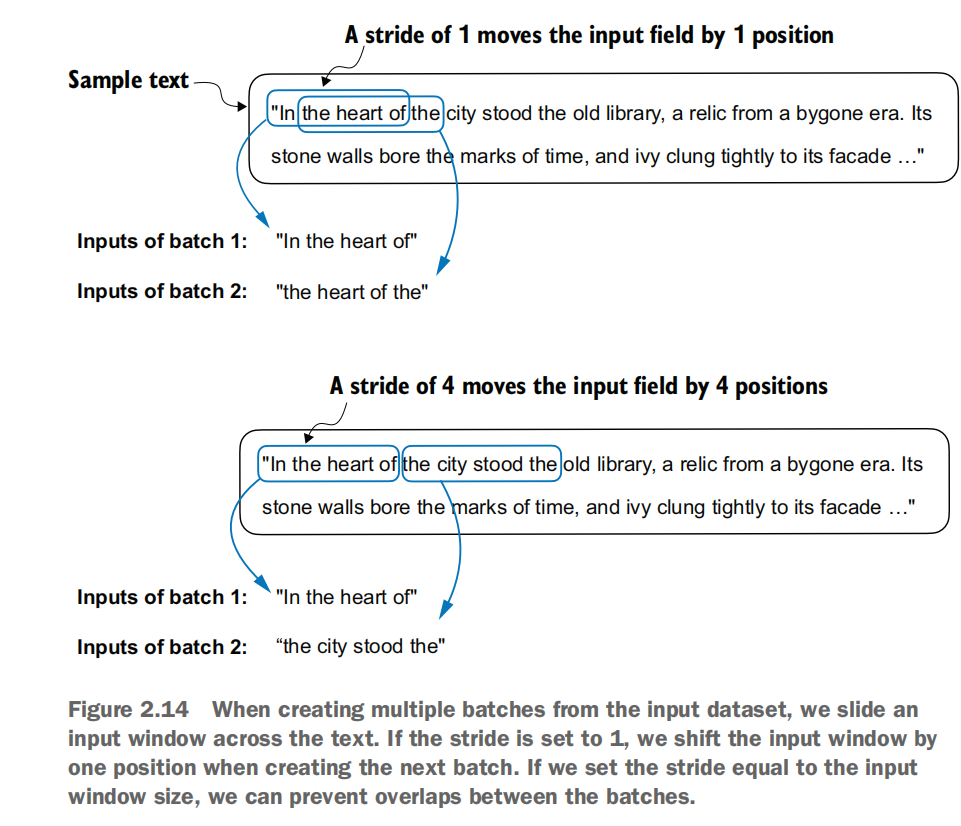

In [73]:
dataloader = create_dataloader_v1(
 raw_text, batch_size=8, max_length=4, stride=4,
 shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


# The Embeddings

In [31]:
# Setting-up a small example of embedding
input_ids = torch.tensor([2, 3, 5, 1])

In [32]:
vocab_size = 6
output_dim = 3

In [33]:
torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
print(embedding_layer.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


In [34]:
print(embedding_layer(torch.tensor([3])))

tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)


If we compare the embedding vector for token ID 3 to the previous embedding\
matrix, we see that it is identical to the fourth row (Python starts with a zero index, so\
it’s the row corresponding to index 3). In other words, the embedding layer is essentially a lookup operation that retrieves rows from the embedding layer’s weight matrix via a token ID.

In [35]:
print(embedding_layer(input_ids))

tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


### Embedding is a lookup operation

![alt text](image-3.png)

# Positional encoding

### Without postional encoding
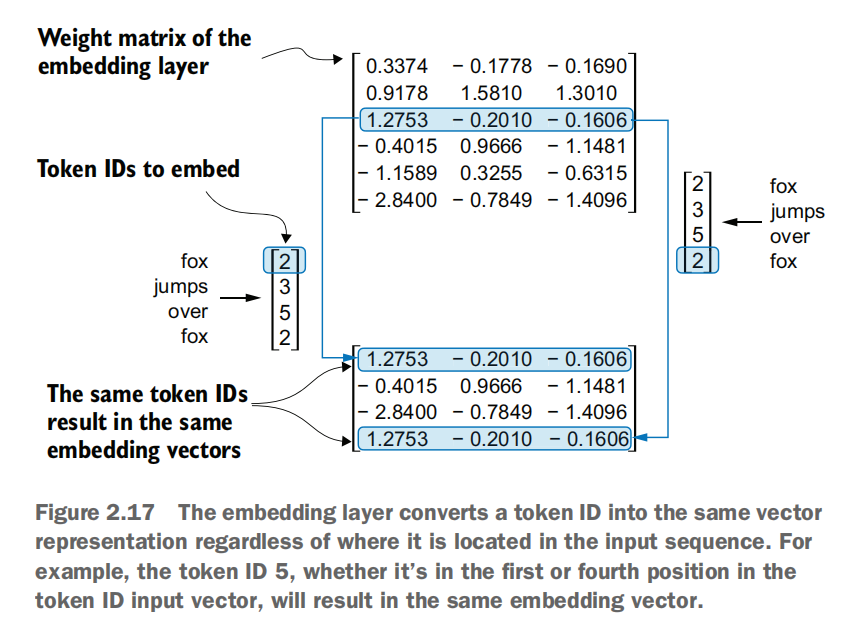 

### Absolute postion encoding

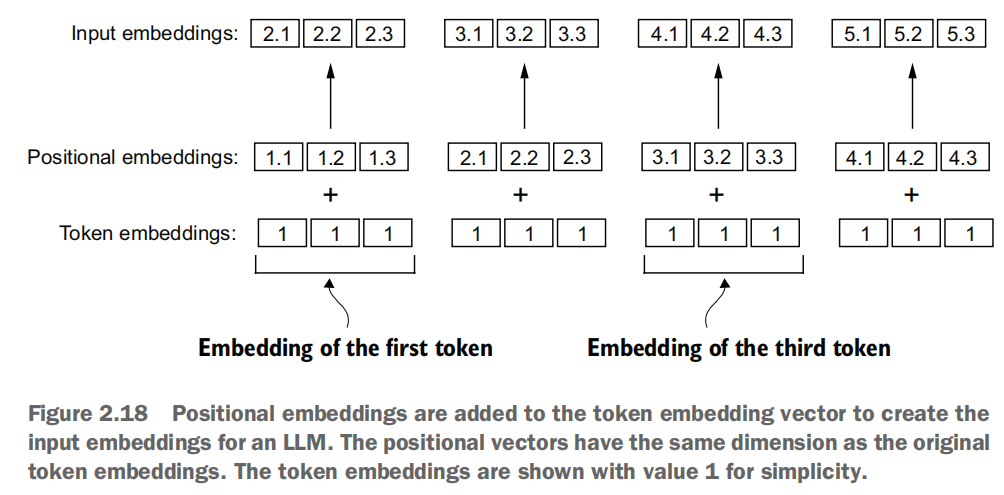

In [36]:
# Now we will proceed with our work
vocab_size = 50257
output_dim = 256
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

In [37]:
max_length = 4
dataloader = create_dataloader_v1(
 raw_text, batch_size=8, max_length=max_length,
 stride=max_length, shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])


In [38]:
# creating embedded tokens using the input tensors 
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

torch.Size([8, 4, 256])


### Each row contains 4 word, each of the word is converted to 256-dim vector

In [39]:
token_embeddings[0]

tensor([[ 0.4913,  1.1239,  1.4588,  ..., -0.3995, -1.8735, -0.1445],
        [ 0.4481,  0.2536, -0.2655,  ...,  0.4997, -1.1991, -1.1844],
        [-0.2507, -0.0546,  0.6687,  ...,  0.9618,  2.3737, -0.0528],
        [ 0.9457,  0.8657,  1.6191,  ..., -0.4544, -0.7460,  0.3483]],
       grad_fn=<SelectBackward0>)

### Absolute postional encoding

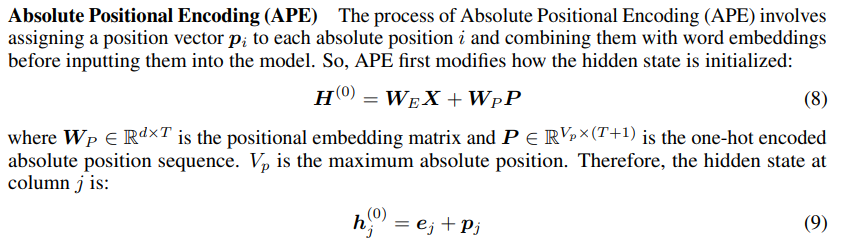

In [40]:
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)
pos_embeddings = pos_embedding_layer(torch.arange(context_length))
print(pos_embeddings.shape)

torch.Size([4, 256])


In the code snippet, the pos_embedding_layer is a PyTorch Embedding layer that maps integer indices to dense vectors.

The pos_embeddings tensor is created by passing a tensor of indices torch.arange(context_length) to the pos_embedding_layer. This means that each integer index in the range of context_length is mapped to a corresponding positional embedding vector.

The positional embeddings are typically learned embeddings that encode the position of each element in a sequence. In this case, the positional embeddings are created for each position in the sequence, ranging from 0 to context_length-1. The embeddings capture the relative positions between elements in the sequence, allowing the model to understand the order and positional information of the input.

In [41]:
pos_embeddings

tensor([[ 1.7375, -0.5620, -0.6303,  ..., -0.2277,  1.5748,  1.0345],
        [ 1.6423, -0.7201,  0.2062,  ...,  0.4118,  0.1498, -0.4628],
        [-0.4651, -0.7757,  0.5806,  ...,  1.4335, -0.4963,  0.8579],
        [-0.6754, -0.4628,  1.4323,  ...,  0.8139, -0.7088,  0.4827]],
       grad_fn=<EmbeddingBackward0>)

In [42]:
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])


## Complete pipeline for input
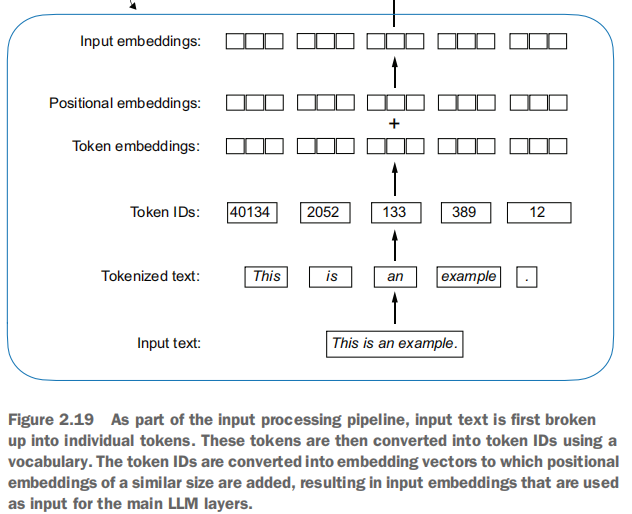

# End of Notebook
